In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl

## Business Understanding

### Description

We are supporting a research team looking for new evidence to better outline the roman civilization chronicles. Wen then want to rent the found antiquities to local museums for them to put on display.

### Question 1:

Which region has the highest count of ancient roman monuments?

### Question 2:

How are cities and monuments related to each other?

### Question 3:

Which of the three regions chosen by our research team (Gallia Lugdunensis, Moesia Inferior, Bithynia et Pontus) should be selected for their exploration? We want the highest probability of finding new monuments.

### First step: Gather

First, we have to fetch the data

In [6]:
def fetchData(url):
    '''Here we fetch the data from my github
    it takes a url and returns the data from the csv under the url
    ''' 
    df = pd.read_csv(url)
    return df

df = fetchData("https://raw.githubusercontent.com/D0nG10vanni/DataScientistBlog/main/Sources.csv")
print(df.head())


               Province  Monuments_Count  Cities_Count  Country
0                   NaN              1.0           NaN      NaN
1                Achaea             38.0           6.0  Albania
2                Achaea           1056.0         103.0   Greece
3              Aegyptus            144.0          47.0    Egypt
4  Africa Proconsularis             74.0           5.0    Libya


### Second step: Cleaning the data

Now, we want to clean the data. It is only necessary to convert datatypes and drop the first row as it is invalid (see printed df above) as well as other null rows

In [7]:
def cleaning(df):
    '''Here we clean the data
    it takes the dataframe from the step before as input and outputs the cleaned dataframe'''
    df = df.dropna(subset=["Province"]).copy()  # dropping rows with missing values in provinces
    df["Monuments_Count"] = pd.to_numeric(df["Monuments_Count"], errors="coerce")
    df["Cities_Count"] = pd.to_numeric(df["Cities_Count"], errors="coerce")
    df = df.dropna() #dropping generally all rows with no values
    return df

df = cleaning(df)
print(df.describe())

       Monuments_Count  Cities_Count
count       102.000000    102.000000
mean         92.852941     13.598039
std         151.608302     18.605471
min           1.000000      1.000000
25%          12.000000      2.000000
50%          45.000000      6.000000
75%          96.750000     16.750000
max        1056.000000    103.000000


### Step 3: Assess data

As can be seen in this overview, we have 102 data rows (= provinces) each averaging about 93 monuments and around 14 cities. 

However, we can also see, that the amount of cities and monuments per province varies heavily, wtih the highest being 103 and 1056 respectively. We should take this into account later on.

### Step 4: Prepare data 

Now that we have to data neatly organized, we can start the analysis. First, we want to define the Feature and the target variables. 

After that, we may create the splits and start training the model

In [8]:
def def_vars(df, *features, target="Monuments_Count"):
    '''here we create a function to be able to efficiently define the features 
    input: Dataframe, all of the features, target is set as count of monuments
    output: X and y (features and target)
    '''
    X = df[list(features)] 
    y = df[target]
    return X, y

In [9]:
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
def split(X, y):
    '''now we create the training and testing split (80:20)
    Input: X and y
    output: X_train, X_test, y_train, y_test'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

### Step 5: Training the model
Now we train a Linear regression model based on data we curated before. First, we have to recall all the steps we took.

In [11]:
df = fetchData("https://raw.githubusercontent.com/D0nG10vanni/DataScientistBlog/main/Sources.csv");
df = cleaning(df);
X, y = def_vars(df, "Cities_Count");
X_train, X_test, y_train, y_test = split(X, y);

print("Preparation completed!")

regression = LinearRegression()
regression.fit(X_train, y_train)

Preparation completed!


LinearRegression()

### Step 6: Evaluate the model

Now we want to test the prediction accuracy of the model

In [12]:
def eval(model):
    '''Here we want to test the prediction accuracy of the model
    input: the model
    output: MSE, R² and average error'''
    y_pred = model.predict(X_test)
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("R²:", r2_score(y_test, y_pred))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Average uncertainty of ± {rmse:.1f} monuments")

eval(regression)

MSE: 2724.38625855613
R²: 0.6725331281447817
Average uncertainty of ± 52.2 monuments


### First one down

Now we have trained our first model and evaluated it. The scores are not bad. However, I think we can do better.

### Improvements

1. I want to introduce a new Model, which can much better handle the large varieties we have in our data, as mentioned in the description of the DataFrame: the gradient boosting regression model
2. I will introduce two new variables, which will help the model to better understand the relationship between monuments and cities


In [13]:
from sklearn.ensemble import GradientBoostingRegressor

### Step 4 again: Preparing the data

As before, we need to prepare the data and reestablish the status quo

In [14]:
def ratios(df):
    '''here we add the new features for gradient boosting regression
    input: the dataframe
    output: the dataframe with the two new columns'''
    df["Cities_per_Monument"] = df["Cities_Count"] / (df["Monuments_Count"] + 1)
    df["Monuments_per_City"] = df["Monuments_Count"] / (df["Cities_Count"] + 1)
    return df

In [15]:
# firstly, we want to recreate the status quo from earlier
df = fetchData("https://raw.githubusercontent.com/D0nG10vanni/DataScientistBlog/main/Sources.csv");
df = cleaning(df);
df = ratios(df) # adding the new variables
# and finally we can create the variables and the train-test-split
X, y = def_vars(df, "Cities_Count", "Cities_per_Monument", "Monuments_per_City"); # adding the two new variables
X_train, X_test, y_train, y_test = split(X, y);

### Step 5 again: Training the model

Again, we have to train the model, this time the new one with the new columns

In [16]:
# now, we will train the model again, this time the new one
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor()

### Step 6 again: Evaluation

Now, we have to test whether or not we have improved our prediction accuracy

In [17]:
eval(gbr) # testing the model

MSE: 609.9363227373593
R²: 0.9266866293241646
Average uncertainty of ± 24.7 monuments


### Big Steps forward

As can be seen, the model improved signicantly. However, I think there is still room for improvement, since there is one more thing, that is fairly easy to do.

Before we do that, let's look at the weights of our new model, since we have more than one feature now.

In [18]:
def weights(model, decimals):
    '''here we check the weights of our features:
    input: the model and the decimals of the weights
    output: the weight of each feature'''
    importances = model.feature_importances_
    for name, imp in zip(X.columns, importances):
        print(f"{name}: {imp:.{decimals}f}")

weights(gbr, 9)

Cities_Count: 0.871743622
Cities_per_Monument: 0.070800179
Monuments_per_City: 0.057456199


### Weights weighing

Despite the new variables not having much weight, their impact is not to be neglected.

### Striving for Perfection

As teasered earlier, I have an idea on how to improve accuracy even further. It involves a variable which we have not taken into account at all yet: __*the countries*__!

In [19]:
# as before, we need to reset everything again
df = fetchData("https://raw.githubusercontent.com/D0nG10vanni/DataScientistBlog/main/Sources.csv");
df = cleaning(df);
df = ratios(df) # adding the two ratio-variables
# now countries are taken into consideration as well
df_encoded = pd.get_dummies(df, columns=["Country"])
feature_cols = ["Cities_Count", "Cities_per_Monument", "Monuments_per_City"] + \
               [col for col in df_encoded.columns if col.startswith("Country_")]
# Create feature matrix and target vector
X, y = def_vars(df_encoded, *feature_cols)
X_train, X_test, y_train, y_test = split(X, y)

In [20]:
# training the model
gbr2 = GradientBoostingRegressor()
gbr2.fit(X_train, y_train)

GradientBoostingRegressor()

In [21]:
# now we can evaluate again
eval(gbr2)
weights(gbr2, 9)

MSE: 632.2823676741411
R²: 0.9240006704551523
Average uncertainty of ± 25.1 monuments
Cities_Count: 0.871693835
Cities_per_Monument: 0.044103369
Monuments_per_City: 0.080478412
Country_Albania: 0.000000295
Country_Algeria: 0.000361178
Country_Austria: 0.000006694
Country_Belgium: 0.000000000
Country_Bosnia and Herzegovina: 0.000000000
Country_Bulgaria: 0.000000000
Country_Croatia: 0.000001194
Country_Cyprus: 0.000000693
Country_Egypt: 0.000011019
Country_France: 0.000027270
Country_Germany: 0.000000000
Country_Greece: 0.002984967
Country_Hungary: 0.000002305
Country_Israel: 0.000000000
Country_Italy: 0.000103460
Country_Jordan: 0.000000000
Country_Kosovo: 0.000000000
Country_Lebanon: 0.000000000
Country_Libya: 0.000001016
Country_Macedonia: 0.000000000
Country_Malta: 0.000000000
Country_Montenegro: 0.000032541
Country_Morocco: 0.000000000
Country_Netherlands: 0.000000009
Country_Northern Cyprus: 0.000000000
Country_Portugal: 0.000000000
Country_Romania: 0.000026300
Country_Serbia: 0.00

### Not better

Despite more details to analyze, the model did not much produce better predictions than our second one. However, an R² of almost 0.94 is exceptional, hence I am very content with my first ML Model.

### Final remarks

I was able to create a model, which is able to predict the count of monuments of a region _pretty accurately_ based on the cities it has. The only thing left to do, is to use the model and create some actual predictions as well as answer our questions from the beginning. For this, I will use the third model, since it yielded the most accurate results.

## Final Evaluation

### Question 1: Which region has the highest count of ancient roman monuments?

This can be easily seen by looking at the following chart:

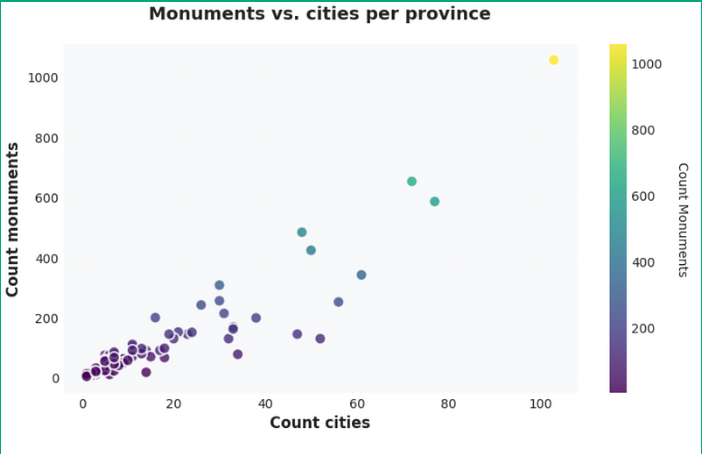

Each dot represents one region from our table. The more cities, the further left and the more monuments, the further up they are placed. The dot with the highest count of monuments represents the region Achaea in Greece.

### Question 2: How are cities and monuments related to each other?

This as well can be seen in the graph plotting our data. There is an obvious relationship between the number of cities and its number of monuments.

### Question 3: Which of the three regions chosen by our research team should be selected for their exploration?

This question shall be answered by our model.

In [27]:
def predict(province_name, model, df_encoded, X_template):
    '''Predicts the number of monuments for a given province
    input: Province, model, the dataframe, the dataset of cities
    output: predicted count of monuments, the actual value and the error'''
    row = df_encoded[df_encoded["Province"] == province_name]
    if row.empty:
        return f"Province '{province_name}' not found in the dataset."

    # Align columns with training features
    X_input = row[X_template.columns].copy()
    actual = row["Monuments_Count"].values[0]
    predicted = model.predict(X_input)[0]

    percent_diff = ((predicted - actual) / actual) * 100
    return (f"Estimated number of monuments in '{province_name}': {predicted:.1f} "
            f"(actually: {actual:.1f}) --> {abs(percent_diff):.1f}% {'over' if predicted > actual else 'under'}")


In [29]:
print(predict("Gallia Lugdunensis", gbr2, df_encoded, X))
print(predict("Moesia Inferior", gbr2, df_encoded, X))
print(predict("Bithynia et Pontus", gbr2, df_encoded, X))

Estimated number of monuments in 'Gallia Lugdunensis': 209.5 (actually: 213.0) --> 1.7% under
Estimated number of monuments in 'Moesia Inferior': 35.7 (actually: 35.0) --> 2.1% over
Estimated number of monuments in 'Bithynia et Pontus': 56.7 (actually: 62.0) --> 8.5% under


### Answering the last question

As can be seen, Gallia Lugdunensis has by far the most monuments, hence it is most lucrative to look there for more evidence of roman civilization. 